# 1. Análisis de Insights para Ofertas Relámpago:

El primer script en este realiza un análisis detallado del conjunto de datos de ofertas relâmpago, con el fin de responder a la siguiente pregunta: "¿Cuál es el mejor período para anunciar una oferta flash de un producto de una determinada categoría?" 

- ## Dependencias.

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
from statsmodels.tsa.api import SARIMAX
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from category_encoders import BinaryEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from statsmodels.tsa.arima.model import ARIMA

- ## Configuraciones.

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option("display.max_colwidth", None)
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
%matplotlib inline

- ## Pipeline.

In [3]:
df = pd.read_csv('ofertas_relampago.csv')
print(df.shape)
display(df)

(48746, 13)


,OFFER_START_DATE,OFFER_START_DTTM,OFFER_FINISH_DTTM,OFFER_TYPE,INVOLVED_STOCK,REMAINING_STOCK_AFTER_END,SOLD_AMOUNT,SOLD_QUANTITY,ORIGIN,SHIPPING_PAYMENT_TYPE,DOM_DOMAIN_AGG1,VERTICAL,DOMAIN_ID
0,2021-06-22,2021-06-22 16:00:00+00:00,2021-06-22 23:02:43+00:00,lightning_deal,4,-2,4.72,6.0,A,none,PETS FOOD,CPG,MLM-BIRD_FOODS
1,2021-06-22,2021-06-22 13:00:00+00:00,2021-06-22 19:00:02+00:00,lightning_deal,5,5,NaN,NaN,NaN,free_shipping,PET PRODUCTS,OTHERS,MLM-ANIMAL_AND_PET_PRODUCTS
2,2021-06-22,2021-06-22 07:00:00+00:00,2021-06-22 13:00:01+00:00,lightning_deal,15,12,10.73,3.0,NaN,none,COMPUTERS,CE,MLM-SPEAKERS
3,2021-06-22,2021-06-22 19:00:00+00:00,2021-06-23 01:36:12+00:00,lightning_deal,15,13,7.03,2.0,NaN,none,COMPUTERS,CE,MLM-HEADPHONES
4,2021-06-22,2021-06-22 13:00:00+00:00,2021-06-22 15:48:12+00:00,lightning_deal,15,0,39.65,15.0,NaN,none,COMPUTERS,CE,MLM-HEADPHONES
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48741,2021-06-19,2021-06-19 13:00:00+00:00,2021-06-19 19:00:01+00:00,lightning_deal,15,9,16.28,6.0,NaN,none,HOME&DECOR,HOME & INDUSTRY,MLM-CHRISTMAS_LIGHTS
48742,2021-06-19,2021-06-19 13:00:00+00:00,2021-06-19 19:00:01+00:00,lightning_deal,5,5,NaN,NaN,NaN,free_shipping,HOME&DECOR,HOME & INDUSTRY,MLM-DECORATIVE_PAINTINGS
48743,2021-06-19,2021-06-19 07:00:00+00:00,2021-06-19 13:00:03+00:00,lightning_deal,5,3,16.62,2.0,NaN,free_shipping,HOME&DECOR,HOME & INDUSTRY,MLM-INDOOR_CURTAINS_AND_BLINDS
48744,2021-06-19,2021-06-19 13:00:00+00:00,2021-06-19 19:00:00+00:00,lightning_deal,5,1,38.79,4.0,NaN,free_shipping,HOME&DECOR,HOME & INDUSTRY,MLM-INDOOR_CURTAINS_AND_BLINDS


- ### EDA

In [4]:
ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
print(f"Min log date: {df['OFFER_START_DATE'].min()}")
print(f"Max log date: {df['OFFER_START_DATE'].max()}")

Min log date: 2021-06-01
Max log date: 2021-07-31


In [6]:
df['DOM_DOMAIN_AGG1'].value_counts()

DOM_DOMAIN_AGG1
HOME&DECOR                      6742
APPAREL ACCESORIES              4387
APPAREL                         3856
COMPUTERS                       3770
SPORTS                          3289
PHARMACEUTICS                   3035
ELECTRONICS                     3018
PERSONAL CARE                   3016
MOBILE                          1841
AUTOPARTS                       1696
FOOTWEAR                        1516
TOOLS AND CONSTRUCTION          1491
TOYS AND GAMES                  1426
STATIONARY                      1259
INDUSTRY                        1199
BEAUTY EQUIPMENT                1099
FOODS                            858
PERSONAL HYGIENE                 840
BABY                             801
MOTOPARTS                        641
BOOKS, MULTIMEDIA & OTHER E!     498
PETS FOOD                        487
PARTY                            397
CLEANING                         360
SECURITY                         320
PET PRODUCTS                     257
SUPLEMENTS            

In [7]:
df['DOMAIN_ID'].value_counts()

DOMAIN_ID
MLM-SURGICAL_AND_INDUSTRIAL_MASKS            1759
MLM-HEADPHONES                                761
MLM-LED_STRIPS                                518
MLM-SUNGLASSES                                472
MLM-VEHICLE_LED_BULBS                         454
                                             ... 
MLM-INSECT_KILLER_LIGHTS                        1
MLM-WATERING_CANS                               1
MLM-BASEBALL_AND_SOFTBALL_FIELDING_GLOVES       1
MLM-HABERDASHERY_BEADS                          1
MLM-ELECTRIC_SANDWICH_MAKERS                    1
Name: count, Length: 1266, dtype: int64

In [8]:
df['VERTICAL'].value_counts()

VERTICAL
APP & SPORTS       13241
HOME & INDUSTRY    11011
CE                  8629
BEAUTY & HEALTH     7150
CPG                 2714
T & B               2624
ACC                 2573
ENTERTAINMENT        525
OTHERS               279
Name: count, dtype: int64

Es interesante ver que la columna que mejor nuclea mejor todos los productos es VERTICAL. Puede ser útil como agrupador para disminuir la varianza.

In [9]:
df['OFFER_START_DATE'].value_counts()

OFFER_START_DATE
2021-07-30    1300
2021-07-29    1299
2021-07-08    1267
2021-07-31    1228
2021-07-28    1214
              ... 
2021-06-07     426
2021-06-06     412
2021-06-09     366
2021-06-08     317
2021-06-30     254
Name: count, Length: 61, dtype: int64

In [10]:
df['OFFER_START_DTTM'] = pd.to_datetime(df['OFFER_START_DTTM'])

In [11]:
df['start_hour'] = df['OFFER_START_DTTM'].dt.hour

In [12]:
df

,OFFER_START_DATE,OFFER_START_DTTM,OFFER_FINISH_DTTM,OFFER_TYPE,INVOLVED_STOCK,REMAINING_STOCK_AFTER_END,SOLD_AMOUNT,SOLD_QUANTITY,ORIGIN,SHIPPING_PAYMENT_TYPE,DOM_DOMAIN_AGG1,VERTICAL,DOMAIN_ID,start_hour
0,2021-06-22,2021-06-22 16:00:00+00:00,2021-06-22 23:02:43+00:00,lightning_deal,4,-2,4.72,6.0,A,none,PETS FOOD,CPG,MLM-BIRD_FOODS,16
1,2021-06-22,2021-06-22 13:00:00+00:00,2021-06-22 19:00:02+00:00,lightning_deal,5,5,NaN,NaN,NaN,free_shipping,PET PRODUCTS,OTHERS,MLM-ANIMAL_AND_PET_PRODUCTS,13
2,2021-06-22,2021-06-22 07:00:00+00:00,2021-06-22 13:00:01+00:00,lightning_deal,15,12,10.73,3.0,NaN,none,COMPUTERS,CE,MLM-SPEAKERS,7
3,2021-06-22,2021-06-22 19:00:00+00:00,2021-06-23 01:36:12+00:00,lightning_deal,15,13,7.03,2.0,NaN,none,COMPUTERS,CE,MLM-HEADPHONES,19
4,2021-06-22,2021-06-22 13:00:00+00:00,2021-06-22 15:48:12+00:00,lightning_deal,15,0,39.65,15.0,NaN,none,COMPUTERS,CE,MLM-HEADPHONES,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48741,2021-06-19,2021-06-19 13:00:00+00:00,2021-06-19 19:00:01+00:00,lightning_deal,15,9,16.28,6.0,NaN,none,HOME&DECOR,HOME & INDUSTRY,MLM-CHRISTMAS_LIGHTS,13
48742,2021-06-19,2021-06-19 13:00:00+00:00,2021-06-19 19:00:01+00:00,lightning_deal,5,5,NaN,NaN,NaN,free_shipping,HOME&DECOR,HOME & INDUSTRY,MLM-DECORATIVE_PAINTINGS,13
48743,2021-06-19,2021-06-19 07:00:00+00:00,2021-06-19 13:00:03+00:00,lightning_deal,5,3,16.62,2.0,NaN,free_shipping,HOME&DECOR,HOME & INDUSTRY,MLM-INDOOR_CURTAINS_AND_BLINDS,7
48744,2021-06-19,2021-06-19 13:00:00+00:00,2021-06-19 19:00:00+00:00,lightning_deal,5,1,38.79,4.0,NaN,free_shipping,HOME&DECOR,HOME & INDUSTRY,MLM-INDOOR_CURTAINS_AND_BLINDS,13


In [13]:
df.drop_duplicates(inplace=True)

In [14]:
df

,OFFER_START_DATE,OFFER_START_DTTM,OFFER_FINISH_DTTM,OFFER_TYPE,INVOLVED_STOCK,REMAINING_STOCK_AFTER_END,SOLD_AMOUNT,SOLD_QUANTITY,ORIGIN,SHIPPING_PAYMENT_TYPE,DOM_DOMAIN_AGG1,VERTICAL,DOMAIN_ID,start_hour
0,2021-06-22,2021-06-22 16:00:00+00:00,2021-06-22 23:02:43+00:00,lightning_deal,4,-2,4.72,6.0,A,none,PETS FOOD,CPG,MLM-BIRD_FOODS,16
1,2021-06-22,2021-06-22 13:00:00+00:00,2021-06-22 19:00:02+00:00,lightning_deal,5,5,NaN,NaN,NaN,free_shipping,PET PRODUCTS,OTHERS,MLM-ANIMAL_AND_PET_PRODUCTS,13
2,2021-06-22,2021-06-22 07:00:00+00:00,2021-06-22 13:00:01+00:00,lightning_deal,15,12,10.73,3.0,NaN,none,COMPUTERS,CE,MLM-SPEAKERS,7
3,2021-06-22,2021-06-22 19:00:00+00:00,2021-06-23 01:36:12+00:00,lightning_deal,15,13,7.03,2.0,NaN,none,COMPUTERS,CE,MLM-HEADPHONES,19
4,2021-06-22,2021-06-22 13:00:00+00:00,2021-06-22 15:48:12+00:00,lightning_deal,15,0,39.65,15.0,NaN,none,COMPUTERS,CE,MLM-HEADPHONES,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48741,2021-06-19,2021-06-19 13:00:00+00:00,2021-06-19 19:00:01+00:00,lightning_deal,15,9,16.28,6.0,NaN,none,HOME&DECOR,HOME & INDUSTRY,MLM-CHRISTMAS_LIGHTS,13
48742,2021-06-19,2021-06-19 13:00:00+00:00,2021-06-19 19:00:01+00:00,lightning_deal,5,5,NaN,NaN,NaN,free_shipping,HOME&DECOR,HOME & INDUSTRY,MLM-DECORATIVE_PAINTINGS,13
48743,2021-06-19,2021-06-19 07:00:00+00:00,2021-06-19 13:00:03+00:00,lightning_deal,5,3,16.62,2.0,NaN,free_shipping,HOME&DECOR,HOME & INDUSTRY,MLM-INDOOR_CURTAINS_AND_BLINDS,7
48744,2021-06-19,2021-06-19 13:00:00+00:00,2021-06-19 19:00:00+00:00,lightning_deal,5,1,38.79,4.0,NaN,free_shipping,HOME&DECOR,HOME & INDUSTRY,MLM-INDOOR_CURTAINS_AND_BLINDS,13


No se tendrá en cuenta la hora de finalización, ya que esta puede manejarse libremente mediante el manejo de stock. Tampoco el tipo de oferta, ya que es comun a todos los atributos.

In [15]:
df.drop(['OFFER_FINISH_DTTM', 'OFFER_TYPE'] , axis=1, inplace=True)

In [16]:
df

,OFFER_START_DATE,OFFER_START_DTTM,INVOLVED_STOCK,REMAINING_STOCK_AFTER_END,SOLD_AMOUNT,SOLD_QUANTITY,ORIGIN,SHIPPING_PAYMENT_TYPE,DOM_DOMAIN_AGG1,VERTICAL,DOMAIN_ID,start_hour
0,2021-06-22,2021-06-22 16:00:00+00:00,4,-2,4.72,6.0,A,none,PETS FOOD,CPG,MLM-BIRD_FOODS,16
1,2021-06-22,2021-06-22 13:00:00+00:00,5,5,NaN,NaN,NaN,free_shipping,PET PRODUCTS,OTHERS,MLM-ANIMAL_AND_PET_PRODUCTS,13
2,2021-06-22,2021-06-22 07:00:00+00:00,15,12,10.73,3.0,NaN,none,COMPUTERS,CE,MLM-SPEAKERS,7
3,2021-06-22,2021-06-22 19:00:00+00:00,15,13,7.03,2.0,NaN,none,COMPUTERS,CE,MLM-HEADPHONES,19
4,2021-06-22,2021-06-22 13:00:00+00:00,15,0,39.65,15.0,NaN,none,COMPUTERS,CE,MLM-HEADPHONES,13
...,...,...,...,...,...,...,...,...,...,...,...,...
48741,2021-06-19,2021-06-19 13:00:00+00:00,15,9,16.28,6.0,NaN,none,HOME&DECOR,HOME & INDUSTRY,MLM-CHRISTMAS_LIGHTS,13
48742,2021-06-19,2021-06-19 13:00:00+00:00,5,5,NaN,NaN,NaN,free_shipping,HOME&DECOR,HOME & INDUSTRY,MLM-DECORATIVE_PAINTINGS,13
48743,2021-06-19,2021-06-19 07:00:00+00:00,5,3,16.62,2.0,NaN,free_shipping,HOME&DECOR,HOME & INDUSTRY,MLM-INDOOR_CURTAINS_AND_BLINDS,7
48744,2021-06-19,2021-06-19 13:00:00+00:00,5,1,38.79,4.0,NaN,free_shipping,HOME&DECOR,HOME & INDUSTRY,MLM-INDOOR_CURTAINS_AND_BLINDS,13


In [17]:
df['units_sold'] = np.where(df['REMAINING_STOCK_AFTER_END'] >= 0, df['INVOLVED_STOCK'] - df['REMAINING_STOCK_AFTER_END'], abs(df['REMAINING_STOCK_AFTER_END']-df['INVOLVED_STOCK']))

In [18]:
df[['INVOLVED_STOCK','REMAINING_STOCK_AFTER_END', 'units_sold']] 	

,INVOLVED_STOCK,REMAINING_STOCK_AFTER_END,units_sold
0,4,-2,6
1,5,5,0
2,15,12,3
3,15,13,2
4,15,0,15
...,...,...,...
48741,15,9,6
48742,5,5,0
48743,5,3,2
48744,5,1,4


In [19]:
df['units_sold'].value_counts()

units_sold
0      22951
1       7424
2       4225
3       2547
5       2477
       ...  
240        1
686        1
250        1
404        1
296        1
Name: count, Length: 246, dtype: int64

In [20]:
df['OFFER_START_DATE'] = pd.to_datetime(df['OFFER_START_DATE'])
df['weekday'] = df['OFFER_START_DATE'].dt.weekday + 1  # El primer día de la semana (lunes) comienza con 1.

In [21]:
df

,OFFER_START_DATE,OFFER_START_DTTM,INVOLVED_STOCK,REMAINING_STOCK_AFTER_END,SOLD_AMOUNT,SOLD_QUANTITY,ORIGIN,SHIPPING_PAYMENT_TYPE,DOM_DOMAIN_AGG1,VERTICAL,DOMAIN_ID,start_hour,units_sold,weekday
0,2021-06-22,2021-06-22 16:00:00+00:00,4,-2,4.72,6.0,A,none,PETS FOOD,CPG,MLM-BIRD_FOODS,16,6,2
1,2021-06-22,2021-06-22 13:00:00+00:00,5,5,NaN,NaN,NaN,free_shipping,PET PRODUCTS,OTHERS,MLM-ANIMAL_AND_PET_PRODUCTS,13,0,2
2,2021-06-22,2021-06-22 07:00:00+00:00,15,12,10.73,3.0,NaN,none,COMPUTERS,CE,MLM-SPEAKERS,7,3,2
3,2021-06-22,2021-06-22 19:00:00+00:00,15,13,7.03,2.0,NaN,none,COMPUTERS,CE,MLM-HEADPHONES,19,2,2
4,2021-06-22,2021-06-22 13:00:00+00:00,15,0,39.65,15.0,NaN,none,COMPUTERS,CE,MLM-HEADPHONES,13,15,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48741,2021-06-19,2021-06-19 13:00:00+00:00,15,9,16.28,6.0,NaN,none,HOME&DECOR,HOME & INDUSTRY,MLM-CHRISTMAS_LIGHTS,13,6,6
48742,2021-06-19,2021-06-19 13:00:00+00:00,5,5,NaN,NaN,NaN,free_shipping,HOME&DECOR,HOME & INDUSTRY,MLM-DECORATIVE_PAINTINGS,13,0,6
48743,2021-06-19,2021-06-19 07:00:00+00:00,5,3,16.62,2.0,NaN,free_shipping,HOME&DECOR,HOME & INDUSTRY,MLM-INDOOR_CURTAINS_AND_BLINDS,7,2,6
48744,2021-06-19,2021-06-19 13:00:00+00:00,5,1,38.79,4.0,NaN,free_shipping,HOME&DECOR,HOME & INDUSTRY,MLM-INDOOR_CURTAINS_AND_BLINDS,13,4,6


In [22]:
df.drop(['INVOLVED_STOCK', 'REMAINING_STOCK_AFTER_END', 'SOLD_AMOUNT', 'SOLD_QUANTITY', 'ORIGIN', 'SHIPPING_PAYMENT_TYPE', 'DOM_DOMAIN_AGG1','DOMAIN_ID']  , axis=1, inplace=True)

In [23]:
df

,OFFER_START_DATE,OFFER_START_DTTM,VERTICAL,start_hour,units_sold,weekday
0,2021-06-22,2021-06-22 16:00:00+00:00,CPG,16,6,2
1,2021-06-22,2021-06-22 13:00:00+00:00,OTHERS,13,0,2
2,2021-06-22,2021-06-22 07:00:00+00:00,CE,7,3,2
3,2021-06-22,2021-06-22 19:00:00+00:00,CE,19,2,2
4,2021-06-22,2021-06-22 13:00:00+00:00,CE,13,15,2
...,...,...,...,...,...,...
48741,2021-06-19,2021-06-19 13:00:00+00:00,HOME & INDUSTRY,13,6,6
48742,2021-06-19,2021-06-19 13:00:00+00:00,HOME & INDUSTRY,13,0,6
48743,2021-06-19,2021-06-19 07:00:00+00:00,HOME & INDUSTRY,7,2,6
48744,2021-06-19,2021-06-19 13:00:00+00:00,HOME & INDUSTRY,13,4,6


In [24]:
df.drop(['OFFER_START_DTTM'] , axis=1, inplace=True)

In [25]:
df

,OFFER_START_DATE,VERTICAL,start_hour,units_sold,weekday
0,2021-06-22,CPG,16,6,2
1,2021-06-22,OTHERS,13,0,2
2,2021-06-22,CE,7,3,2
3,2021-06-22,CE,19,2,2
4,2021-06-22,CE,13,15,2
...,...,...,...,...,...
48741,2021-06-19,HOME & INDUSTRY,13,6,6
48742,2021-06-19,HOME & INDUSTRY,13,0,6
48743,2021-06-19,HOME & INDUSTRY,7,2,6
48744,2021-06-19,HOME & INDUSTRY,13,4,6


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47820 entries, 0 to 48745
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   OFFER_START_DATE  47820 non-null  datetime64[ns]
 1   VERTICAL          47820 non-null  object        
 2   start_hour        47820 non-null  int32         
 3   units_sold        47820 non-null  int64         
 4   weekday           47820 non-null  int32         
dtypes: datetime64[ns](1), int32(2), int64(1), object(1)
memory usage: 1.8+ MB


In [27]:
df.columns

Index(['OFFER_START_DATE', 'VERTICAL', 'start_hour', 'units_sold', 'weekday'], dtype='object')

In [28]:
df['month'] = df['OFFER_START_DATE'].dt.month

In [29]:
df

,OFFER_START_DATE,VERTICAL,start_hour,units_sold,weekday,month
0,2021-06-22,CPG,16,6,2,6
1,2021-06-22,OTHERS,13,0,2,6
2,2021-06-22,CE,7,3,2,6
3,2021-06-22,CE,19,2,2,6
4,2021-06-22,CE,13,15,2,6
...,...,...,...,...,...,...
48741,2021-06-19,HOME & INDUSTRY,13,6,6,6
48742,2021-06-19,HOME & INDUSTRY,13,0,6,6
48743,2021-06-19,HOME & INDUSTRY,7,2,6,6
48744,2021-06-19,HOME & INDUSTRY,13,4,6,6


Eliminaremos los outliers de units sold

In [30]:
Q1 = df['units_sold'].quantile(0.25)
Q3 = df['units_sold'].quantile(0.75)
IQR = Q3 - Q1

lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

df = df[(df['units_sold'] >= lower_limit) & (df['units_sold'] <= upper_limit)]

In [31]:
df

,OFFER_START_DATE,VERTICAL,start_hour,units_sold,weekday,month
0,2021-06-22,CPG,16,6,2,6
1,2021-06-22,OTHERS,13,0,2,6
2,2021-06-22,CE,7,3,2,6
3,2021-06-22,CE,19,2,2,6
5,2021-06-22,CE,18,0,2,6
...,...,...,...,...,...,...
48741,2021-06-19,HOME & INDUSTRY,13,6,6,6
48742,2021-06-19,HOME & INDUSTRY,13,0,6,6
48743,2021-06-19,HOME & INDUSTRY,7,2,6,6
48744,2021-06-19,HOME & INDUSTRY,13,4,6,6


Se fitearan tres regresores sin optimización de hiperparámetros, buscando aquel cuyo estimador de error (en este caso el MSE) sea el menor. Se probarán dos técnicas de codificación de variables categóricas nominales.

- ### Regresión lineal.

In [32]:
X = df[['VERTICAL', 'start_hour', 'weekday', 'month']]
y = df['units_sold']

# Binary Encoder
encoder = BinaryEncoder(cols=['VERTICAL'])
X_encoded = encoder.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

predictions = lr_model.predict(X_val)

# MSE
mse = mean_squared_error(y_val, predictions)
print(f'Mean Squared Error binary encoder: {mse}')

Mean Squared Error binary encoder: 3.0562594278029604


In [33]:
X = df[['VERTICAL', 'start_hour', 'weekday', 'month']]
y = df['units_sold']

# One hot encoding
X_encoded = pd.get_dummies(X, columns=['VERTICAL'], prefix=['VERTICAL'])

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

predictions = lr_model.predict(X_val)

# MSE
mse = mean_squared_error(y_val, predictions)
print(f'Mean Squared Error one hot encoding: {mse}')

Mean Squared Error one hot encoding: 3.0471785723113958


- ### Gradient Boosting Regressor.

In [34]:
X = df[['VERTICAL', 'start_hour', 'weekday', 'month']]
y = df['units_sold']

encoder = BinaryEncoder(cols=['VERTICAL'])
X_encoded = encoder.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

gb_model_binary = GradientBoostingRegressor(random_state=42)
gb_model_binary.fit(X_train, y_train)

predictions = gb_model_binary.predict(X_val)

# MSE
mse = mean_squared_error(y_val, predictions)
print(f'Mean Squared Error binary encoder: {mse}')

Mean Squared Error binary encoder: 3.0107109874821356


In [35]:
X = df[['VERTICAL', 'start_hour', 'weekday', 'month']]
y = df['units_sold']

# One hot encoding
X_encoded = pd.get_dummies(X, columns=['VERTICAL'], prefix=['VERTICAL'])

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)

predictions = gb_model.predict(X_val)

# MSE
mse = mean_squared_error(y_val, predictions)
print(f'Mean Squared Error one hot encoding: {mse}')

Mean Squared Error one hot encoding: 3.011421005461438


- ### Random Forest Regressor

In [36]:
X = df[['VERTICAL', 'start_hour', 'weekday', 'month']]
y = df['units_sold']

# One hot encoding
X_encoded = pd.get_dummies(X, columns=['VERTICAL'], prefix=['VERTICAL'])

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100,random_state=42)
rf_model.fit(X_train, y_train)

predictions = rf_model.predict(X_val)

# MSE
mse = mean_squared_error(y_val, predictions)
print(f'Mean Squared Error one hot encoding: {mse}')

Mean Squared Error one hot encoding: 3.0270980475039333


In [37]:
X = df[['VERTICAL', 'start_hour', 'weekday', 'month']]
y = df['units_sold']

encoder = BinaryEncoder(cols=['VERTICAL'])
X_encoded = encoder.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100,random_state=42)
rf_model.fit(X_train, y_train)

predictions = rf_model.predict(X_val)

# MSE
mse = mean_squared_error(y_val, predictions)
print(f'Mean Squared Error binary encoder: {mse}')

Mean Squared Error binary encoder: 3.0275184978642566


El mejor fue el gradient boosting con codificación one-hot encoding. Veamos como performa en test:

In [38]:
predictions = gb_model_binary.predict(X_test)

In [39]:
mean_squared_error(y_test, predictions) 

3.1012943949227085

Veamos como performó analizando un dataframe.

In [40]:
test = pd.DataFrame()

In [41]:
test = X_test
test['predictions'] = predictions
test['units_sold'] = y_test

In [42]:
test[['units_sold', 'predictions']][0:30]

,units_sold,predictions
16958,1,1.594726
37029,0,1.411388
24800,0,1.386637
3645,0,1.326423
2292,0,1.536966
25080,2,0.968248
16679,0,1.006637
39989,0,1.274342
35206,2,1.244913
13044,0,1.336535


In [43]:
test['difference'] = test['units_sold'] - test['predictions']  

In [44]:
test[['units_sold', 'predictions', 'difference']]

,units_sold,predictions,difference
16958,1,1.594726,-0.594726
37029,0,1.411388,-1.411388
24800,0,1.386637,-1.386637
3645,0,1.326423,-1.326423
2292,0,1.536966,-1.536966
...,...,...,...
48423,0,1.332659,-1.332659
3424,0,1.074231,-1.074231
12321,0,1.441535,-1.441535
20785,0,0.968248,-0.968248


In [45]:
test.difference.describe()

count    8581.000000
mean        0.000907
std         1.761152
min        -1.968688
25%        -1.244034
50%        -0.750942
75%         0.630853
max         6.215237
Name: difference, dtype: float64

Si bien la desviación standart es pequeña, lo cual nos dice que los valores tiender a variar poco. **Es interesante ver que el  75% de los datos se encuentra por debajo de 0.63** lo cuál es aceptable, pero se encuentra sesgado por valores positivos y negativos.

In [46]:
test['difference_abs'] = abs(test['difference'])

In [47]:
test.difference_abs.describe()

count    8581.000000
mean        1.368714
std         1.108179
min         0.001069
25%         0.707304
50%         1.123211
75%         1.524672
max         6.215237
Name: difference_abs, dtype: float64

La desviación standart es menor si tomamos el módulo de la diferencia. **Es interesante ver que el  75% de los datos se encuentra por debajo de 1.52** lo cuál es muy aceptable y representativo al tomar el módulo. Este modelo será elegido como el **baseline**

---------------------------------------------------------------------------------------------------------------------

Otro approach a realizar: tener en cuenta el día en que la oferta comienza y las unidades vendidas por vertical totales por día.

In [48]:
df2 = df[df['VERTICAL']=='CPG']

In [49]:
df2 = df2.groupby(by=df2['OFFER_START_DATE'])['units_sold'].sum().reset_index()

In [50]:
df2.index = pd.to_datetime(df2['OFFER_START_DATE'], format='%Y-%m-%d')

In [51]:
df2.drop(['OFFER_START_DATE'] , axis=1, inplace=True)

In [52]:
df2.iloc[48] # Aprox el 80% de los datos se encuentran desde el 01-06-2021 hasta el 19-07-2021

units_sold    49
Name: 2021-07-19 00:00:00, dtype: int64

In [53]:
df2

,units_sold
OFFER_START_DATE,
2021-06-01,29
2021-06-02,33
2021-06-03,14
2021-06-04,34
2021-06-05,2
...,...
2021-07-27,49
2021-07-28,80
2021-07-29,30


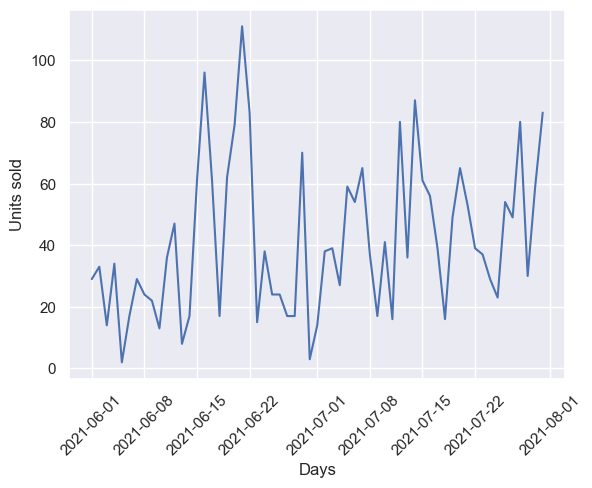

In [54]:
sns.set()
plt.ylabel('Units sold')
plt.xlabel('Days')
plt.xticks(rotation=45)
plt.plot(df2.index.values, df2['units_sold'].values)
plt.show()

Se nota cierta estacionalidad por días.

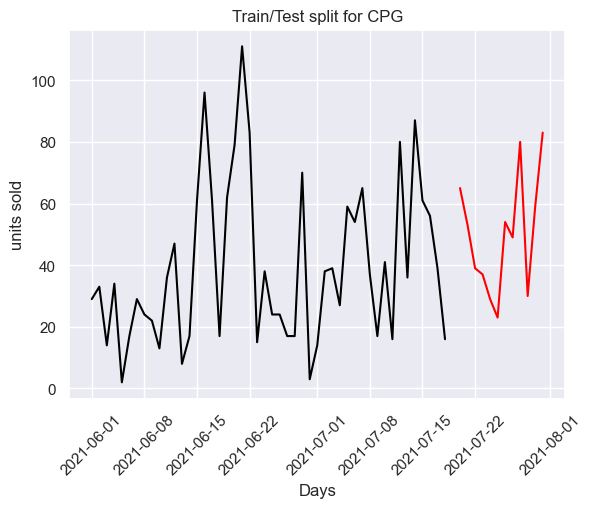

In [55]:
train = df2[df2.index < pd.to_datetime("2021-07-19", format='%Y-%m-%d')]
test = df2[df2.index > pd.to_datetime("2021-07-19", format='%Y-%m-%d')]

plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.ylabel('units sold')
plt.xlabel('Days')
plt.xticks(rotation=45)
plt.title("Train/Test split for CPG")
plt.show()

In [56]:
total_rows = len(train)
rows_to_remove = int(0.1 * total_rows)
val = train.head(rows_to_remove).copy()
train = train.tail(total_rows - rows_to_remove).copy()

In [57]:
val

,units_sold
OFFER_START_DATE,
2021-06-01,29
2021-06-02,33
2021-06-03,14
2021-06-04,34


In [58]:
train

,units_sold
OFFER_START_DATE,
2021-06-05,2
2021-06-06,17
2021-06-07,29
2021-06-08,24
2021-06-09,22
2021-06-10,13
2021-06-11,36
2021-06-12,47
2021-06-13,8


- ### Autoregressive Moving Average (ARMA)

In [59]:
y = train['units_sold']

ARMAmodel = SARIMAX(y, order = (1, 0, 1))

ARMAmodel = ARMAmodel.fit()
y_pred = ARMAmodel.get_forecast(len(val.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = val.index
y_pred_out = y_pred_df["Predictions"]

mse = mean_squared_error(val['units_sold'].values, y_pred_out)
print(f'Mean Squared Error: {mse}')

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.74725D+00    |proj g|=  8.56219D-02

At iterate    5    f=  4.73148D+00    |proj g|=  7.13991D-03

At iterate   10    f=  4.72975D+00    |proj g|=  6.31157D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     17      1     0     0   2.184D-06   4.730D+00
  F =   4.7297157133628298     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Mean Squared Error: 94.77575310653057


 This problem is unconstrained.


- ### ARIMA

In [60]:
ARIMAmodel = ARIMA(y, order = (2, 2, 2))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(val.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = val.index
y_pred_out = y_pred_df["Predictions"] 

mse = mean_squared_error(val['units_sold'].values, y_pred_out)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 348.88887962596266


- ### SARIMAX

In [61]:
SARIMAXmodel = SARIMAX(y, order = (5, 4, 2), seasonal_order=(2,2,2,12))
SARIMAXmodel = SARIMAXmodel.fit()

y_pred = SARIMAXmodel.get_forecast(len(val.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = SARIMAXmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = val.index
y_pred_out = y_pred_df["Predictions"] 

mse = mean_squared_error(val['units_sold'].values, y_pred_out)
print(f'Mean Squared Error: {mse}')

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.21508D+00    |proj g|=  1.15320D+00


 This problem is unconstrained.



At iterate    5    f=  2.28528D+00    |proj g|=  3.57098D-02

At iterate   10    f=  2.27707D+00    |proj g|=  4.47120D-03

At iterate   15    f=  2.27560D+00    |proj g|=  2.06325D-03

At iterate   20    f=  2.27553D+00    |proj g|=  7.50092D-04

At iterate   25    f=  2.27527D+00    |proj g|=  1.83054D-03

At iterate   30    f=  2.27468D+00    |proj g|=  9.44327D-03

At iterate   35    f=  2.26812D+00    |proj g|=  1.80985D-02

At iterate   40    f=  2.25652D+00    |proj g|=  2.18604D-02

At iterate   45    f=  2.25023D+00    |proj g|=  5.11070D-03

At iterate   50    f=  2.24535D+00    |proj g|=  2.27199D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

Puede notarse que los errores adoptados por estos métodos son mayores a los del enfoque de aprendizaje automático y no serán tenidos en cuenta. Puede deberse también a su complejidad a la hora de ajustar los hiperparámetros intervinientes.

- ## Conclusiones

Se logró encontrar un baseline con resultados aceptables para poder predecir las unidades vendidas. Sería deseable realizar un estudio más a fondo sobre cada vertical y realizar un estudio más exhaustivo de los hiperparámetros tanto de los regresores como de los modelos estadísticos o la utilización de variables exógenas. Sería interesante ver la performance de los modelos con una mayor cantidad de datos, ya que se cuenta solo con los valores de 1 mes.